# **Proyek 1: Natural Language Processing**

### Nico Marcelino

## Downloading Data

In [1]:
# install package and upload API key
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"helixneek","key":"dcfc8fada4acacb6f21efd5d5de301be"}'}

In [2]:
# change permissions and make directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
# download and unzip file
!kaggle datasets download -d hgultekin/bbcnewsarchive

!mkdir bbcnewsarchive.zip
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchive

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 125MB/s]
mkdir: cannot create directory ‘bbcnewsarchive.zip’: File exists
Archive:  bbcnewsarchive.zip
  inflating: bbcnewsarchive/bbc-news-data.csv  
bbc-news-data.csv


## Preparing Dataset

In [4]:
# make dataframe
import pandas as pd

df = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')
df = df.drop(columns=['title', 'filename'])
df.head()

,category,content
0,business,Quarterly profits at US media giant TimeWarne...
1,business,The dollar has hit its highest level against ...
2,business,The owners of embattled Russian oil giant Yuk...
3,business,British Airways has blamed high fuel prices f...
4,business,Shares in UK drinks and food firm Allied Dome...


## Data Preprocessing

In [5]:
# one-hot encoding
category = pd.get_dummies(df.category)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='category')
new_df

,content,business,entertainment,politics,sport,tech
0,Quarterly profits at US media giant TimeWarne...,1,0,0,0,0
1,The dollar has hit its highest level against ...,1,0,0,0,0
2,The owners of embattled Russian oil giant Yuk...,1,0,0,0,0
3,British Airways has blamed high fuel prices f...,1,0,0,0,0
4,Shares in UK drinks and food firm Allied Dome...,1,0,0,0,0
...,...,...,...,...,...,...
2220,BT is introducing two initiatives to help bea...,0,0,0,0,1
2221,Computer users across the world continue to i...,0,0,0,0,1
2222,A new European directive could put software w...,0,0,0,0,1
2223,The man making sure US computer networks are ...,0,0,0,0,1


In [6]:
# import libraries
import nltk, re, string
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
# make all characters lowercase
new_df['content'] = new_df['content'].str.lower()

# removing stopwords
stop_words = stopwords.words('english')
new_df['content'] = new_df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# non-alphumeric character handling
new_df["content"] = new_df['content'].str.replace('[^\w\s]','')

new_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


,content,business,entertainment,politics,sport,tech
0,quarterly profits us media giant timewarner ju...,1,0,0,0,0
1,dollar hit highest level euro almost three mon...,1,0,0,0,0
2,owners embattled russian oil giant yukos ask b...,1,0,0,0,0
3,british airways blamed high fuel prices 40 dro...,1,0,0,0,0
4,shares uk drinks food firm allied domecq risen...,1,0,0,0,0
...,...,...,...,...,...,...
2220,bt introducing two initiatives help beat rogue...,0,0,0,0,1
2221,computer users across world continue ignore se...,0,0,0,0,1
2222,new european directive could put software writ...,0,0,0,0,1
2223,man making sure us computer networks safe secu...,0,0,0,0,1


In [8]:
# membuat set training dan test dari content dan category
from sklearn.model_selection import train_test_split

content = new_df['content'].values
category = new_df[['business', 'entertainment', 'politics', 'sport', 'tech']].values
content_train, content_test, category_train, category_test = train_test_split(content, category, test_size=0.2, shuffle=True)

In [9]:
# tokenisasi
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
     
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(content_train)

train_sequence = tokenizer.texts_to_sequences(content_train)
test_sequence = tokenizer.texts_to_sequences(content_test)

train_padded = pad_sequences(train_sequence, maxlen=50, padding='post', truncating='post') 
test_padded = pad_sequences(test_sequence, maxlen=50, padding='post', truncating='post')

In [10]:
# model building
import tensorflow as tf
from keras.layers import LSTM

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=10000, output_dim=32),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam' ,metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 419,589
Trainable params: 419,589
Non-trainable params: 0
_________________________________________________________________


In [11]:
# callback ketika kedua akurasi >90%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
        print("\nBoth accuracies are at over 90%!")
        self.model.stop_training = True
callbacks = myCallback()

In [12]:
# model fitting
num_epochs = 50

history = model.fit(train_padded, category_train, epochs=num_epochs, shuffle=True,
                    validation_data=(test_padded, category_test), verbose=2, callbacks=[callbacks])

Epoch 1/50
56/56 - 13s - loss: 1.4926 - accuracy: 0.3118 - val_loss: 1.1518 - val_accuracy: 0.4315 - 13s/epoch - 231ms/step
Epoch 2/50
56/56 - 6s - loss: 0.9363 - accuracy: 0.5713 - val_loss: 0.8405 - val_accuracy: 0.6697 - 6s/epoch - 101ms/step
Epoch 3/50
56/56 - 7s - loss: 0.5596 - accuracy: 0.7427 - val_loss: 0.6494 - val_accuracy: 0.7101 - 7s/epoch - 118ms/step
Epoch 4/50
56/56 - 4s - loss: 0.2187 - accuracy: 0.9169 - val_loss: 0.4998 - val_accuracy: 0.8764 - 4s/epoch - 71ms/step
Epoch 5/50
56/56 - 4s - loss: 0.1223 - accuracy: 0.9624 - val_loss: 0.4109 - val_accuracy: 0.8697 - 4s/epoch - 63ms/step
Epoch 6/50
56/56 - 3s - loss: 0.0221 - accuracy: 0.9944 - val_loss: 0.5339 - val_accuracy: 0.8494 - 3s/epoch - 62ms/step
Epoch 7/50
56/56 - 3s - loss: 0.0714 - accuracy: 0.9787 - val_loss: 0.3651 - val_accuracy: 0.8719 - 3s/epoch - 62ms/step
Epoch 8/50

Both accuracies are at over 90%!
56/56 - 3s - loss: 0.0209 - accuracy: 0.9944 - val_loss: 0.3408 - val_accuracy: 0.9326 - 3s/epoch - 61m

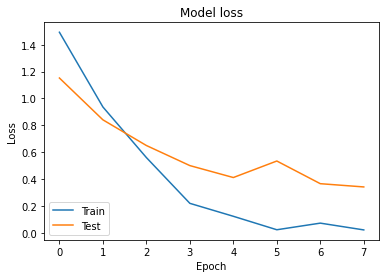

In [13]:
# plot loss dari model
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
plt.show()

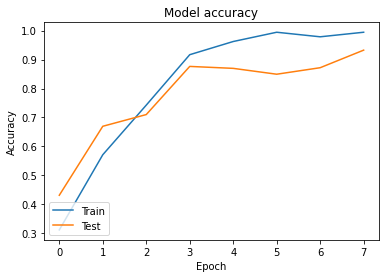

In [14]:
# plot akurasi dari model 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
plt.show()